## Illustration of sRRR on Scala (2021) data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

from sparseRRR import elastic_rrr, elastic_rrr_bootstrap, elastic_rrr_cv, dimensionality, bibiplot, plot_cv_results 
from sklearn.exceptions import ConvergenceWarning

In [4]:
def preprocess(data):
    X = data['counts'][:,data['mostVariableGenes']] / np.sum(data['counts'], axis=1) * 1e+6
    X = X.toarray()
    X = np.log2(X + 1)
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    Y = data['ephys']
    Y = Y - np.mean(Y, axis=0)
    Y = Y / np.std(Y, axis=0)
    
    return (X,Y)

In [5]:
data = pickle.load(open('../data/scala2020.pickle', 'rb'))

X,Y = preprocess(data)
genes = data['genes'][data['mostVariableGenes']]

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (1213, 1000) 
Shape of Y: (1213, 16)


/var/folders/j9/6j6_y95j0tl4lmss_d5lyv3w0000gn/T/ipykernel_5830/3105051235.py:1: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(open('../data/scala2020.pickle', 'rb'))


In [6]:
w,v = elastic_rrr(X, Y, rank=2, alpha=.285, l1_ratio=1)

print('\nGenes selected: {}'.format(np.sum(w[:,0]!=0)))
print(', '.join(genes[w[:,0]!=0]))


Genes selected: 24
Arpp21, Atp1a3, Bcan, Bdnf, Cacna1e, Cacna2d1, Coro6, Erbb4, Gad1, Kcnc2, Kcnv1, Mybpc1, Npy1r, Nxph1, Pcsk2, Plch2, Ptk2b, Pvalb, Slc17a7, Slc6a1, Snca, Tac1, Tafa1, Tmem44


Text(0.5, 1.0, 'Sorted row l2-norms of $W$')

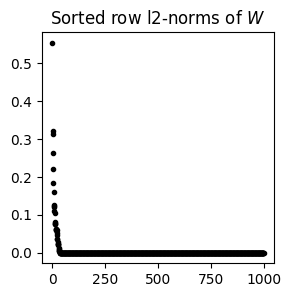

In [7]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(np.sort(np.linalg.norm(w, axis=1))[::-1], '.', color='black')
ax.set_title(r'Sorted row l2-norms of $W$')

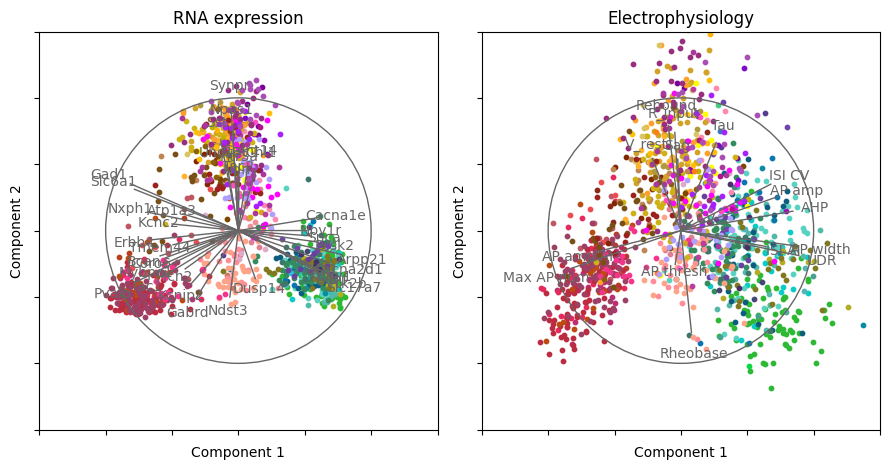

In [8]:
bibiplot(X, Y, w, v, 
         titles = ['RNA expression', 'Electrophysiology'],
         cellTypes = data['ttype'], 
         cellTypeColors = data['colors'], 
         YdimsNames = data['ephysNames'], 
         XdimsNames = genes
         )

In [64]:
alphas = np.arange(.2,1.01,.1)
l1_ratios = np.array([.75, 1])

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=(ConvergenceWarning, RuntimeWarning))
    cvResults = elastic_rrr_cv(X, Y, l1_ratios=l1_ratios, alphas=alphas)


1.......... Time: 0.0h 25m 15s


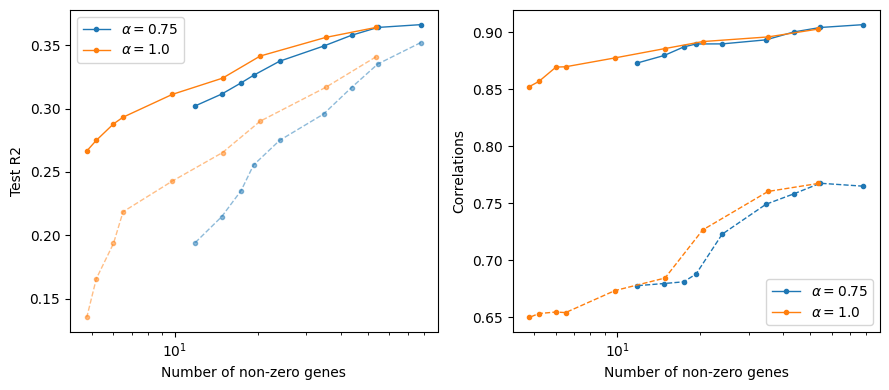

In [65]:
plot_cv_results(*cvResults, l1_ratios)

In [67]:
bootCounts = elastic_rrr_bootstrap(X, Y, alpha=.4, l1_ratio=1)

args = np.argsort(bootCounts)[::-1]
print('')
for i in range(20):
    print('{:10} {:.2f}'.format(genes[args[i]], bootCounts[args[i]]))

.................................................................................................... 

Cacna2d1   1.00
Gad1       1.00
Pvalb      0.99
Arpp21     0.99
Slc6a1     0.95
Erbb4      0.94
Nxph1      0.88
Coro6      0.86
Mybpc1     0.78
Ptk2b      0.77
Tac1       0.77
Bcan       0.71
Cacna1e    0.65
Slc17a7    0.38
Snca       0.38
Bdnf       0.30
Baiap2     0.27
Tafa1      0.27
Plch2      0.24
Sv2b       0.24


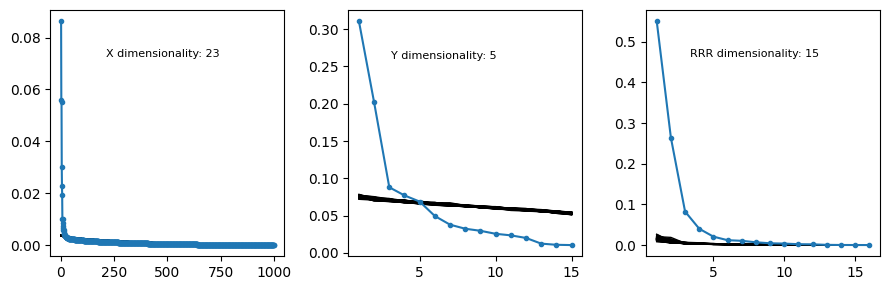

In [75]:
# A quick and dirty way to estimate the dimensionality
dimensionality(X, Y)